In [1]:
from __future__ import print_function

import os
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
import matplotlib.pyplot as plt

import pandas as pd

from src.model.pmf import PMF
 
# from src.model.embedding import UserMovieEmbedding

In [2]:
import numpy as np

def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [3]:
print('------------------------ Train PMF ---------------------------')
# --------------------------------------------- HYPERPARAMETERS ----------------------------------------------------
# Input batch size for training
batch_size = 1000
# Number of maximum epoches to train
epoches = 1000
# Enables CUDA training
no_cuda = False
# Generate random seed
seed = 1
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 50
# Training ratio
ratio = 0.8
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9

------------------------ Train PMF ---------------------------


In [4]:
# unix datetime
base = pd.Timestamp("1970-01-01")
CHUNK_SIZE = 1000000
RATING_DROP = 0
MOVIE_PATH = 'dataset/movies.csv'
RATING_PATH = 'dataset/ratings.csv'
USERS_PATH = 'dataset/users.csv'

In [5]:
rp = pd.read_csv(RATING_PATH)
rp.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [6]:
rp["rating"] = rp["rating"].astype("float")
rp = rp.sort_values(["user_id", "timestamp"])
rp.head()


,user_id,movie_id,rating,timestamp
59972,0,167,5.0,874965478
92487,0,171,5.0,874965478
74577,0,164,5.0,874965518
48214,0,155,4.0,874965556
15764,0,195,5.0,874965677


In [7]:
data = rp[["user_id", "movie_id", "rating"]].values
 
# Normalize rewards to [-1, 1]
data[:,2] = 0.5*(data[:,2] - 3)

data

array([[  0., 167.,   1.],
       [  0., 171.,   1.],
       [  0., 164.,   1.],
       ...,
       [942., 229.,  -1.],
       [942., 227.,   0.],
       [942., 233.,   0.]])

In [8]:
# Shuffle data
np.random.shuffle(data)

In [9]:
# Split data
train_data = data[:int(ratio*data.shape[0])]
vali_data = data[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio+(1-ratio)/2)*data.shape[0]):]

In [10]:
train_data

array([[ 6.710e+02,  1.800e+02,  0.000e+00],
       [ 8.900e+01,  2.570e+02,  0.000e+00],
       [ 2.200e+02,  2.140e+02,  5.000e-01],
       ...,
       [ 5.590e+02,  1.018e+03,  5.000e-01],
       [ 4.440e+02,  1.220e+02, -1.000e+00],
       [ 4.700e+01,  2.930e+02,  0.000e+00]])

In [11]:
NUM_USERS = 943  # 6040
NUM_ITEMS = 1682 # 3883

In [12]:
# Get CUDA device if available
cuda = torch.cuda.is_available()
 
# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")
 
# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)
 
# Specify number of workers for cuda
kwargs = {'num_workers':1, 'pin_memory':True} if cuda else {}
 
# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

In [13]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
 
# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction='sum')

# Set optimizer (uncomment Adam for adam)
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# model = UserMovieEmbedding()

Model moved to CUDA


In [14]:
# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row 2, item_id_nums: col 4 , ratings: val 1
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda:
            _row = row.cuda()
            _col = col.cuda()
            _val = val.cuda()
 
        # Train
        preds = model.forward(_row, _col)
        #print("PREDS ", preds)
        #print("_VAL", _val)
        loss = loss_function(preds, _val)
        #print("LOSS ", loss)
        #raise "PUTS"
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.data
 
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [15]:
# training model part
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(ratio, batch_size, epoches, weight_decay))
print(model)

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:1000, epoches:1000, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(943, 50)
  (item_embeddings): Embedding(1682, 50)
  (ub): Embedding(943, 1)
  (ib): Embedding(1682, 1)
)


In [16]:
 # Go through epochs
for epoch in range(1, epoches+1):
 
    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)
 
    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())
 
    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long())
 
    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)
 
    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())
 
    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 2])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 2])
 
    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
 
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))
 
    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
      last_vali_rmse = vali_rmse
 

Training epoch: 1, training rmse: 0.575056, vali rmse:0.572348
Training epoch: 2, training rmse: 0.564755, vali rmse:0.562843
Training epoch: 3, training rmse: 0.554970, vali rmse:0.553878
Training epoch: 4, training rmse: 0.545749, vali rmse:0.545531
Training epoch: 5, training rmse: 0.537171, vali rmse:0.537863
Training epoch: 6, training rmse: 0.529295, vali rmse:0.530915
Training epoch: 7, training rmse: 0.522154, vali rmse:0.524704
Training epoch: 8, training rmse: 0.515759, vali rmse:0.519221
Training epoch: 9, training rmse: 0.510092, vali rmse:0.514437
Training epoch: 10, training rmse: 0.505118, vali rmse:0.510302
Training epoch: 11, training rmse: 0.500785, vali rmse:0.506757
Training epoch: 12, training rmse: 0.497027, vali rmse:0.503732
Training epoch: 13, training rmse: 0.493779, vali rmse:0.501161
Training epoch: 14, training rmse: 0.490972, vali rmse:0.498975
Training epoch: 15, training rmse: 0.488542, vali rmse:0.497115
Training epoch: 16, training rmse: 0.486431, vali

------------------------------------------- Testing Model------------------------------------------------
Test rmse: 0.455793


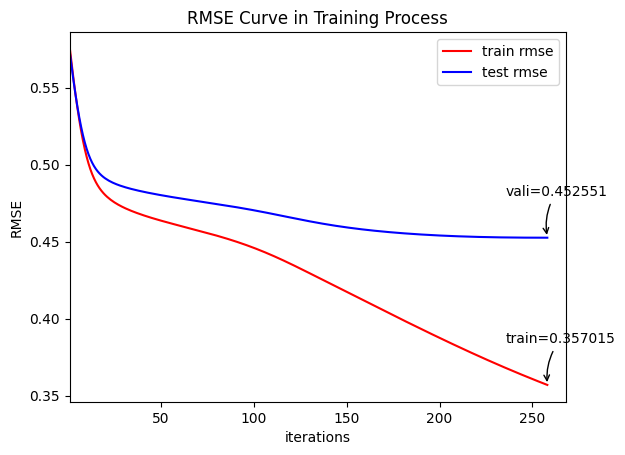

In [17]:
print('------------------------------------------- Testing Model------------------------------------------------')
 
# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long())
 
# Get test predictions
preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2])
print('Test rmse: {:f}'.format(test_rmse))
 
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()
 
# Save model
path_to_trained_pmf = 'dataset/data_runs/emb_{:d}_ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt'.format(embedding_feature_size, ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [18]:
idx =  0
#torch.tensor([data[idx][0]]).to(device)
#torch.tensor([data[idx][1]]).to(device)
 
model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] * 2 + 3

tensor(3.3105)

In [19]:
data[idx][2] * 2 + 3

3.0